In [1]:
import pandas as pd
import numpy as np
import folium
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [44]:
!pip install lxml --quiet
!pip install folium --quiet

In [40]:
CLIENT_ID = 'MY_CLIENT_ID'
CLIENT_SECRET = 'MY_CLIENT_SECRET'
VERSION = '20180323'


#This is the most important funcion, it makes a call to the api using the latitude, longitude, e category id of the venues,
#and return a list of tuples with total amount by category.
def get_total_venues(lat,lng,categories):

    total = []
    RADIUS = 500
    LIMIT = 100

    for c in categories:
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            c[1],
            lat, 
            lng, 
            RADIUS, 
            LIMIT)

        results = requests.get(url).json()['response']
        if len(results) > 0:
            total.append((c[0],len(results['venues'])))
    return total       

#This function makes a premium call to the foursquare API and get a JSON with the categories of the venues.
def get_categories():

    categories = []
    url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)
    result = requests.get(url).json()['response']
    for c in result['categories']:
        categories.append((c['name'],c['id']))
    
    return categories

#Function to fill out the dataframe with the total venues by category
def fill_categories(dataframe):
    for index, row in dataframe.iterrows():
        venues = get_total_venues(row['Latitude'],row['Longitude'],categories)
        for c in venues:
            dataframe.loc[index,c[0]] = c[1] 
    return dataframe           

<h3>Getting the data</h3>
<p>Pulling out the data from the wikipedia article URL and transforming it into a pandas dataframe.</p>

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
toronto = pd.read_html(url)[0]

<h3>Cleaning the data</h3>
<p>Checking out if there's any Borough with no neighborhood assigned, the rule is if there's no neighborhood assigned but theres a Borough the neighborhood is the same as the borough. In this case we got 0. </p>

In [5]:
toronto[(toronto['Neighborhood'] == 'Not assigned') & (toronto['Borough'] != 'Not assigned') ].count()

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

In [6]:
#Replace all 'Not assigned' rows with NAN
toronto.replace('Not assigned',np.nan, inplace=True)

In [7]:
#Drop the NAN rows and reset the index
toronto = toronto.dropna().reset_index(drop=True)

In [379]:
toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [380]:
toronto.shape

(103, 3)

<h3>Merging datasets </h3>
<p>At this point we need all the coordinates for the postal codes, we merge the 2 datasets together on the postal code column. </p>

In [8]:
coordinates = pd.read_csv('https://cocl.us/Geospatial_data')

In [9]:
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
toronto = pd.merge(toronto,coordinates,on='Postal Code')

In [384]:
toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h3>Visualizing The data</h3>
<p>Let's now create a map of the city of Toronto to better understand where its boroughs are located </p>

In [10]:
toro_map = folium.Map(location=[43.71,-79.51], zoom_start = 11) 
toro_map

In [41]:
#Group by boroughs and get the mean values of latitude and longitude
boroughs = toronto.groupby('Borough').mean().reset_index()
boroughs

,Borough,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Central Toronto,43.701980,-79.398954,0,0,0,0,0,0,0,0,0,0
1,Downtown Toronto,43.654597,-79.383972,0,0,0,0,0,0,0,0,0,0
2,East Toronto,43.669436,-79.324654,0,0,0,0,0,0,0,0,0,0
3,East York,43.700303,-79.335851,0,0,0,0,0,0,0,0,0,0
4,Etobicoke,43.660043,-79.542074,0,0,0,0,0,0,0,0,0,0
5,Mississauga,43.636966,-79.615819,0,0,0,0,0,0,0,0,0,0
6,North York,43.750727,-79.429338,0,0,0,0,0,0,0,0,0,0
7,Scarborough,43.766229,-79.249085,0,0,0,0,0,0,0,0,0,0
8,West Toronto,43.652653,-79.449290,0,0,0,0,0,0,0,0,0,0
9,York,43.690797,-79.472633,0,0,0,0,0,0,0,0,0,0


In [12]:
#Now we create a marker for each borough to better visualize where tey are located.
for label,lat,long in zip(boroughs['Borough'],boroughs['Latitude'],boroughs['Longitude']):
    folium.Marker(location=[lat,long], popup=label).add_to(toro_map)

In [13]:
toro_map

In [39]:
#Use the function get_categories to get all the categories
categories = get_categories()

In [15]:
#Add the categories columns to the dataset
for c in categories:
    toronto[c[0]] = 0

In [21]:
toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,0,0,0,0,0,0,0,0,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,0,0,0,0,0


<h2>Filling the dataset</h2>
<p>The main idea behind this project is to classify neighborhoods into cluster where they share similar characteristics</p></br>
<p>The venues are separated in 10 main categories that best describe its business. Then we will fill out each category with the correspondent number of business in those categories for each neighborhood.</p>

In [22]:
#Creates a copy of the toronto dataset, not to mess with the original one.
toronto_filled = toronto.copy()

In [23]:
#Calls the fill_categories function that makes a call for each neighborhood using latitude and longitutde, and fill out the dataset.
toronto_filled = fill_categories()

In [24]:
toronto_filled.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,1,0,1,0,4,9,4,4,4
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,1,0,5,0,4,19,7,16,4
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,49,8,4,49,28,46,45,37,40,32
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,5,1,0,13,2,6,28,0,40,1
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,46,48,0,50,42,45,49,48,42,34
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0,0,0,2,0,3,2,1,1,3
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,0,0,3,0,3,20,0,12,0
7,M3B,North York,Don Mills,43.745906,-79.352188,3,6,0,10,1,12,45,0,9,1
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2,0,0,23,4,5,19,2,29,6
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,41,46,1,49,46,42,45,48,49,36


<h2>Data Preprocessing</h2>
<p>Now that we have all the dataset filled out we can preprocess the data to train the scientific model in order to do data analysis. We will also perform data normalization as number of venues in certain categories can vary significantly.</p>

In [25]:
#Create a features dataset, dropping columns we won't need.
features = toronto_filled.drop(columns=['Borough','Neighborhood','Postal Code'], axis=1)
columns = []
for c in categories:
    columns.append(c[0])

In [26]:
#Performs data normalization
scaler = StandardScaler()
X = scaler.fit_transform(features[columns])
features[columns] = X

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<h2>Finding the optimum number of clusters</h2>
<p>To find the ideal number of clusters the dataset fits in to we will use the elbow method to find the optimum N. In this case it's 3</p>

In [42]:
#Calculates the inertia distance for each number of clusters ranging from 1 to 9
errors = []
for clu in range(1,10):
    kmeans = KMeans(n_clusters=clu,init='k-means++')
    kmeans.fit(features)
    errors.append(kmeans.inertia_)

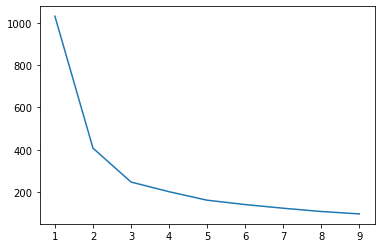

In [43]:
#Lets visualize the plot to find the elbow! Clearly its 3
plt.plot(range(1,10),errors)

<h2>Clustering - K-MEANS Algorithm</h2>
<p>For this study we will be using the K-MEANS algorithm to get our neighborhoods clustered.</p>

In [46]:
#Creating a kmeans object with the opitmum hyperparameters. We fit the model with the features data.
kmeans = KMeans(n_clusters=3,init='k-means++')
kmeans.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
#Creates a cluster column in our dataset and fill it out with the labels generated by our model.
toronto_filled['cluster'] = kmeans.labels_

<h2>Cluster Analysis</h2>
<p>Lets see the mean of each cluster and what characteristics they have</p>

In [50]:
toronto_filled.groupby('cluster').mean()

,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
cluster,,,,,,,,,,,,
0,43.719115,-79.396629,0.857143,0.696429,0.017857,5.375000,1.053571,3.767857,9.625000,1.767857,8.375000,2.250000
1,43.652158,-79.388841,43.125000,29.250000,2.125000,49.062500,42.625000,41.687500,45.875000,38.937500,41.687500,31.625000
2,43.705472,-79.402390,8.677419,2.548387,0.064516,34.419355,7.612903,14.258065,33.774194,8.419355,36.290323,6.806452


<h2>Defining the 3 clusters</h2>
<p>We can notice the neighborhoods are clustered in 3 groups wich can be defined as:</p>
<b><p>Calm, boring, bad public transport Neighborhood </p></b>
<b><p>Diverse, busy, good public transport Neighborhood </p></b>
<b><p>Diverse, Professional, reasonable public transport Neighborhood </p></b>

In [111]:
mapa = folium.Map(location=[43.73,-79.35], zoom_start = 11) 

for index,cluster in toronto_filled.iterrows():
    if cluster[15] == 1:
        folium.Marker(location=[cluster[3],cluster[4]], popup=str(cluster[15]), icon=folium.Icon(color='red')).add_to(mapa)
    elif cluster[15] == 2:
        folium.Marker(location=[cluster[3],cluster[4]], popup=str(cluster[15]), icon=folium.Icon(color='orange')).add_to(mapa)    
    else:
        folium.Marker(location=[cluster[3],cluster[4]], popup=str(cluster[15]), icon=folium.Icon(color='blue')).add_to(mapa)


<h2>Visualizing The distribuition of clusters throughout the city of Toronto</h2>
<p>I am colouring the Neighborhoods based on their clusters </p>
<b><p>Cluster 0 - BLUE </p></b>
<b><p>Cluster 1 - RED</p></b>
<b><p>Cluster 2 - ORANGE</p></b>

In [112]:
mapa

<h2>Conclusions</h2>
<p>It's very clear that the most busy neighborhoods with many shops are located in the heart of Toronto, although we also see calm and quiet neighborhoods with bad public transport nearby very close to busy ones.</p>
<p>Now you can use this interactive map to find a new home in a neighborhood that fits better for you, or if you are looking to open a shop we can also use it.</p>

<p>Thanks for reading this project!</p>
<b><p>Author: Christian Fuin</p></b>